In [1]:
import csv
import time 
import datetime
from statistics import mean, median, stdev
from dateutil import parser
import numpy as np
from random import randint

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import dgl
import dgl.function as fn

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

Using backend: pytorch


In [2]:
class Node():
    
    def __init__(self, typ, address):
        self.typ = typ
        self.address = address
        self.txs_in = []
        self.txs_out = []
        
    def add_tx_in(self, tx):
        self.txs_in.append(tx)
        
    def add_tx_out(self, tx):
        self.txs_out.append(tx)
        
    def agg_txs_amounts(self, txs):
        amounts = []
        for tx in txs:
            amounts.append(float(tx[2]))
        return amounts
    
    def txs_time_series(self, txs): #calculate mins between transactions
        times = []
        
        for i, tx in enumerate(txs):
       
            if i == 0:
                continue
                
            d = parser.parse(tx[1])
            d_prev = parser.parse(txs[i - 1][1])
            diff = d - d_prev
            duration_in_s = diff.total_seconds()
            mins = divmod(duration_in_s, 60)[0]
            times.append(mins)
            
        return times
            
    
    def stats(self, l):
        min_val = 0 if len(l) == 0 else min(l)
        max_val = 0 if len(l) == 0 else max(l)
        avg = 0 if len(l) == 0 else mean(l)
        med = 0 if len(l) == 0 else median(l)
        std = 0 if len(l) in [0, 1] else stdev(l)
        
        return len(l), min_val, max_val, avg, med, std
        
    
    def feature_vector(self):
        in_amounts = self.agg_txs_amounts(self.txs_in)
        out_amounts = self.agg_txs_amounts(self.txs_out)
        all_amounts = self.agg_txs_amounts(self.txs_in + self.txs_out)
        
        in_num, in_min, in_max, in_mean, in_med, in_std = self.stats(in_amounts)
        out_num, out_min, out_max, out_mean, out_med, out_std = self.stats(out_amounts)
        comb_num, comb_min, comb_max, comb_mean, comb_med, comb_std = self.stats(all_amounts)

        in_time_series = self.txs_time_series(self.txs_in)
        out_time_series = self.txs_time_series(self.txs_out)
        both = self.txs_in + self.txs_out
        both.sort(key= lambda x: parser.parse(x[1]))
        all_time_series = self.txs_time_series(both)
        
        _, in_ts_min, in_ts_max, in_ts_mean, in_ts_med, in_ts_std = self.stats(in_time_series)
        _, out_ts_min, out_ts_max, out_ts_mean, out_ts_med, out_ts_std = self.stats(out_time_series)        
        _, all_ts_min, all_ts_max, all_ts_mean, all_ts_med, all_ts_std = self.stats(all_time_series)   
        
        ls =  [
                in_num, in_min, in_max, in_mean, in_med, in_std,
                out_num, out_min, out_max, out_mean, out_med, out_std,
                comb_num, comb_min, comb_max, comb_mean, comb_med, comb_std,
                in_ts_min, in_ts_max, in_ts_mean, in_ts_med, in_ts_std,
                out_ts_min, out_ts_max, out_ts_mean, out_ts_med, out_ts_std,
                all_ts_min, all_ts_max, all_ts_mean, all_ts_med, all_ts_std

               ]

        return np.array(ls)
    
    def one_hot_label(self, classes):
        label_vec = [0] * len(classes)
        for index, acc in enumerate(classes):
            if acc == self.typ:
                label_vec[index] = 1
                break
        return label_vec
            
        
    
    def __str__(self):
        return f"{self.typ}: {len(self.txs_in)} in, {len(self.txs_out)} out"

dummy = Node('', '')
feat_length = len(dummy.feature_vector())
feat_mask = [True] * feat_length

In [3]:
def import_transactions(filename):
    transactions = []
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0

        for row in csv_reader:
            if line_count == 0:
                headers = row
            else:
                transactions.append(row)

            line_count +=1
    return transactions

In [4]:
def import_exchanges(filename):
    exchanges = {}
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            exchanges[row[0]] = ''
            
    return exchanges

In [5]:
def extract_users(tx):
    return tx[3], tx[4]

def extract_types(tx, aug=True):
    s = tx[6]
    r = tx[7]
    
    if aug:
        if (s == 'DEX' or tx[3] in exchanges.keys()): 
            s = 'Exchange'
        if (r == 'DEX' or tx[4] in exchanges.keys()): 
            r = 'Exchange'
        if (s == 'Token' or s == 'Multisig'):
            s = 'Smart Contract'
        if (r == 'Token' or r == 'Multisig'):
            r = 'Smart Contract'
        
    return s, r

In [6]:
def make_nodes(transactions, aug):
    nodes = {}

    for tx in transactions:

        sender, receiver = extract_users(tx)
        sender_typ, receiver_typ = extract_types(tx, aug)

        if sender not in nodes:
            nodes[sender] = Node(sender_typ, sender)

        if receiver not in nodes:
            nodes[receiver] = Node(receiver_typ, receiver)

        nodes[sender].add_tx_out(tx)
        nodes[receiver].add_tx_in(tx)
        
    return nodes

In [7]:
def accounts_stats(nodes):
    acc_dist = {}

    for addr, node in nodes.items():
        if node.typ in acc_dist.keys():
            acc_dist[node.typ] += 1
        else:
            acc_dist[node.typ] = 0
            
    print(acc_dist)
    return acc_dist, list(acc_dist.keys())

In [8]:
def nodes_preprocess(nodes, classes, feats_mask):
    l = len(nodes)
    feat_length = sum(feats_mask)
    
    addresses = np.empty((l,1), dtype=object)
    features = np.empty((l, feat_length), dtype='float32')
    labels = np.empty((l, classes_length), int)
    
    for i, (addr, node) in enumerate(nodes.items()):
        addresses[i] = addr
        feats = np.array(node.feature_vector())
        features[i] = feats[feats_mask]
        labels[i] = node.one_hot_label(classes)
    
    return addresses, features, labels

In [9]:
def normalize(vec):
    mins = vec.min(axis=0)
    maxs = vec.max(axis=0)
    return (vec - mins) / (maxs - mins)

def log_normalize(vec):
    return np.where(vec <= 1, 1, np.log(vec))

def denormalize(maxs, mins, vec):
    return vec * (maxs - mins) + mins

In [10]:
def address_to_id(addresses):
    node_dict = {}

    for i in range(len(addresses)):
        node_dict[addresses[i][0]] = i
    
    return node_dict

In [11]:
def build_edges(transactions, node_table):
    l = len(transactions)
    u = np.empty((l), int)
    v = np.empty((l), int)
    e = np.empty((l), float)
    
    for i, tx in enumerate(transactions):
        if tx[3] in node_table.keys() and tx[4] in node_table.keys():
            print()
            u[i] = node_table[tx[3]]
            v[i] = node_table[tx[4]]
            e[i] = float(tx[2])
            
    return u, v, e

In [12]:
def transform_edges(e):
    e = normalize(e)
    
    e = np.float32(e)
    e = torch.from_numpy(e)
    e = e.to(torch.device('cuda:0'))
    #pad the edges features with 0's for the self loops
    e = nn.ConstantPad1d((0, len(g.edges) - len(e)), 1)(e)
    
    return e

In [13]:
def shuffle(addresses, features, labels):
    assert len(labels) == len(addresses) == len(features)
    p = np.random.permutation(len(labels))
    labels = labels[p]
    addresses = addresses[p]
    features = features[p]
    
    return addresses, features, labels

In [14]:
def to_tensor(arr, float32=False):
    if float32:
        arr = np.float32(arr)
    
    arr = torch.from_numpy(arr)
    return arr

def to_gpu(tens):
    tens = tens.to(torch.device('cuda:0'))
    return tens


In [15]:
def class_weights(acc_dist):
    total = 0
    for x in acc_dist.values():
        total += x
    
    for acc in acc_dist.keys():
        acc_dist[acc] /= total
        acc_dist[acc] = 1 - acc_dist[acc]
    
    classes_w = np.array(list(acc_dist.values()))
    
    return classes_w

In [16]:
def train_test_mask(length):

    train_mask = np.empty((length,1), bool)

    mask_border = int(length // 1.25) #80% train, 20% test

    for i in range(length):
        train_mask[i] = True if i < mask_border else False

    test_mask = np.invert(train_mask) 
    
    return train_mask, test_mask

In [17]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        
        return correct.item() * 1.0 / len(labels)

In [18]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.tight_layout()
    plt.ylabel('True label',fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    
def accuracy(matrix):
    total = 0
    for x in matrix:
        total += sum(x)
        
    correct = 0
    for i in range(len(matrix)):
        correct += matrix[i][i]
        
    return correct / total

def precision(matrix, j):
    col_sum = 0
    for i in range(len(matrix)):
        col_sum += matrix[i][j]
        
    return 0 if col_sum == 0 else matrix[j][j] / col_sum

def recall(matrix, i):
    row_sum = sum(matrix[i])
    
    return 0 if row_sum == 0 else matrix[i][i] / row_sum

def mac_avg_metric(matrix, metric):
    res = []
    
    for i in range(len(matrix)):
        res.append(metric(matrix, i))
        
    return sum(res) / len(res)

def f1_score(precision, recall):
    
    return 2* ((precision * recall) / (precision + recall))

In [19]:
#Message function options:
basic_msg = fn.copy_src(src='h', out='m')
msg_mul = fn.u_mul_e('h', 'w', 'm')

def msg_func_cat(edges):
    return {'m': torch.cat((edges.src['h'], edges.data['w'].unsqueeze(1)), 1)} 

def msg_func_mul(edges):
    return {'m': edges.data['w'][:, None] * edges.src['h']}
    
def msg_func_add(edges):
    return {'m': edges.data['w'][:, None] + edges.src['h']}

def msg_func_combi(edges):
    return {'m':  ((edges.src['h'] + edges.data['w'][:, None])) + ((edges.dst['h'] + edges.data['w'][:, None]))}


## Script:

In [20]:
#feature masks
all_features = [True] * Node.feat_length
test_mask = [True] * 10 + [False] * 17

In [21]:
tx_file = "eos_txs_2018_1.csv"
aug = True
feat_mask = all_features

#------------------------------------------------------------------------------------------#
#Data preprocessing#
print(f"Fetching transactions from {tx_file}")
exchanges = import_exchanges("exchanges.csv")
print(f"{len(exchanges)} exchanges")
transactions = import_transactions(tx_file)
print(f"{len(transactions)} transactions")

#Setup nodes
nodes = make_nodes(transactions, aug)
acc_dist, classes = accounts_stats(nodes)
classes_length = len(classes)

#Nodes processing
print("Processing nodes")
addresses, features, labels = nodes_preprocess(nodes, classes, feat_mask)

print(features)

addresses, features, labels = shuffle(addresses, features, labels)
f_copy = features #copy for 
features = normalize(features)

#Graph assembly#
#------------------------------------------------------------------------------------------#
print("Building transaction graph")
node_dict = address_to_id(addresses)
u, v, e = build_edges(transactions, node_dict) #TRANSACTIONS SHOULD BE A CLASS,

#graph
c_weights = class_weights(acc_dist)
train_mask, test_mask = train_test_mask(len(addresses))

features_tensor = to_tensor(features, True)
labels_tensor = to_tensor(labels, True)
labels_class_indices = torch.max(labels_tensor, 1).indices
train_mask = to_tensor(train_mask).squeeze()
test_mask = to_tensor(test_mask).squeeze()
c_weights = to_tensor(c_weights, True)

features_tensor = to_gpu(features_tensor)
labels_tensor = to_gpu(labels_tensor)
labels_class_indices = to_gpu(labels_class_indices)
train_mask = to_gpu(train_mask)
test_mask = to_gpu(test_mask)
c_weights = to_gpu(c_weights)

g = dgl.DGLGraph((u,v))
g = dgl.transform.add_self_loop(g)

e = transform_edges(e)
g.edata['w'] = e

g = to_gpu(g)

Fetching transactions from eos_txs_2018_1.csv
326 exchanges
353321 transactions
{'Wallet': 168493, 'Exchange': 37, 'Smart Contract': 9422}
Processing nodes
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [6.1810000e+03 4.2061338e-01 4.5000000e+06 ... 2.0760987e+00
  1.0000000e+00 3.5102248e+00]
 [1.7591000e+04 8.3846003e-01 1.2280000e+06 ... 9.5459986e-01
  0.0000000e+00 2.0576916e+00]
 ...
 [1.0000000e+00 4.7178986e+01 4.7178986e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 3.4841827e+01 3.4841827e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 4.9643581e+01 4.9643581e+01 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
Building transaction graph































































































































































































































































In [22]:
#Message and aggregation function
MSG_FUNC = msg_mul
gcn_reduce = fn.sum(msg='m', out='h')

In [23]:
#Architecture
def mid_point(in_feats, classes):
    return ((in_feats - classes) // 2) + classes

class GCNLayer(nn.Module):
    
    def __init__(self, in_feats, out_feats, msg_func, feat_pad = 0):
        super(GCNLayer, self).__init__()
        self.msg_func = msg_func
        self.linear = nn.Linear(in_feats + feat_pad, out_feats)  
        
    def forward(self, g, feature):
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(self.msg_func, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

class Net(nn.Module):
    def __init__(self, msg_func, pad):
        super(Net, self).__init__()
        mid = mid_point(feat_length, classes_length)
        self.layer1 = GCNLayer(feat_length, mid, msg_func, pad)
        self.layer2 = GCNLayer(mid, mid, msg_func, pad)
        self.layer3 = nn.Linear(mid, classes_length)
  
    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = F.relu(self.layer2(g, x))
        x = F.relu(self.layer3(x))
        
        return F.log_softmax(x, 1)

In [25]:
#Build GNN
net = Net(MSG_FUNC, 0)
net.cuda() #make sure uses GPU
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=33, out_features=18, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=18, out_features=18, bias=True)
  )
  (layer3): Linear(in_features=18, out_features=3, bias=True)
)


In [27]:
#Train
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
dur = []
for epoch in range(1000):

    if epoch >= 3:
        t0 = time.time()
        
    net.train()
    out = net(g, features_tensor)
    loss = F.nll_loss(out[train_mask], labels_class_indices[train_mask], c_weights)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch >= 3:
        dur.append(time.time() - t0)
    
#     acc = evaluate(net, g, features_tensor, labels_class_indices, test_mask)
#     print(f"Epoch {epoch} | Loss {loss.item()} | Test acc {acc}  | Time(s) {np.mean(dur)}")

In [28]:
#Test
test_logits = net(g, features_tensor)
test_logits = test_logits[test_mask]
_, indices = torch.max(test_logits, dim=1)
test_labels = labels_class_indices[test_mask]

c_matrix = np.zeros((classes_length, classes_length), int)

for i in range(len(test_labels)):
    accounts = classes
    pred = indices[i]
    label = test_labels[i]
    
#     print(f"Label {accounts[label]}, predicted {accounts[pred]}")
    
    c_matrix[label][pred] += 1

DGLGraph(num_nodes=177955, num_edges=530345,
         ndata_schemes={}
         edata_schemes={'w': Scheme(shape=(), dtype=torch.float32)})
Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=33, out_features=18, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=18, out_features=18, bias=True)
  )
  (layer3): Linear(in_features=18, out_features=3, bias=True)
)
Confusion matrix, without normalization
[[ 4967     8 28649]
 [    8     1     3]
 [   39     0  1916]]
Accuracy: 0.1934
Precision: 0.3881, Recall: 0.4037
F1 score: 0.3958


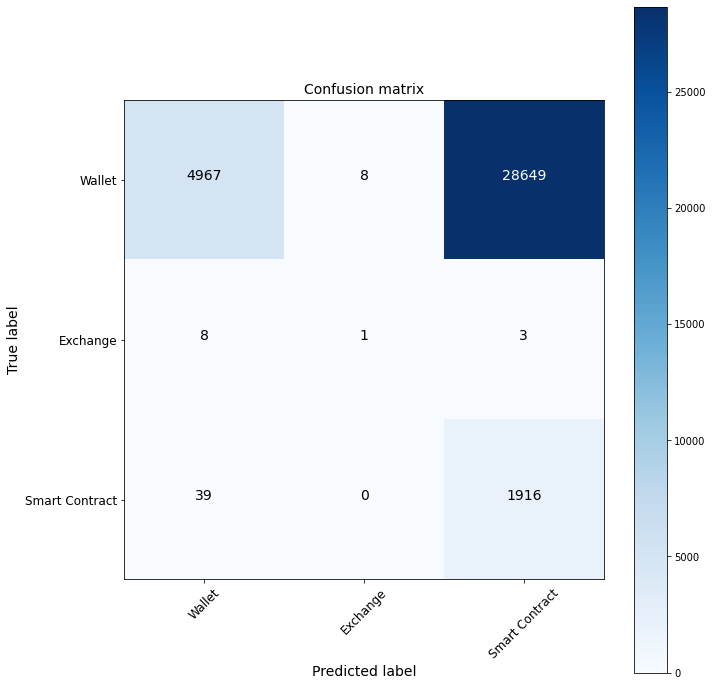

In [29]:
#Summary
print(g)
print(net)
print(MSG_FUNC)
plt.figure(figsize=(10,10))
plot_confusion_matrix(c_matrix, classes)
print(f"Accuracy: {accuracy(c_matrix).round(4)}")
p = mac_avg_metric(c_matrix, precision)
r = mac_avg_metric(c_matrix, recall)
print(f"Precision: {p.round(4)}, Recall: {r.round(4)}")
print(f"F1 score: {f1_score(p,r).round(4)}")

## Play Sound on Completion (optional)

In [30]:
from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 1

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

## Analysis Functions

### Dummy classifier comparison

In [34]:
import numpy as np
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(features_tensor[train_mask].cpu(), labels_class_indices[train_mask].cpu())
print(dummy_clf.score(features_tensor[test_mask].cpu(), labels_class_indices[test_mask].cpu()))
y = dummy_clf.predict(features_tensor[test_mask].cpu())

0.8983450872411565


In [35]:
d_matrix = np.zeros((classes_length, classes_length), int)
d_labels = labels_class_indices[test_mask]
for i in range(len(y)):
    pred = y[i]
    label = d_labels[i]
    
    d_matrix[label][pred] += 1

Confusion matrix, without normalization
[[31838     8  1778]
 [   12     0     0]
 [ 1864     0    91]]


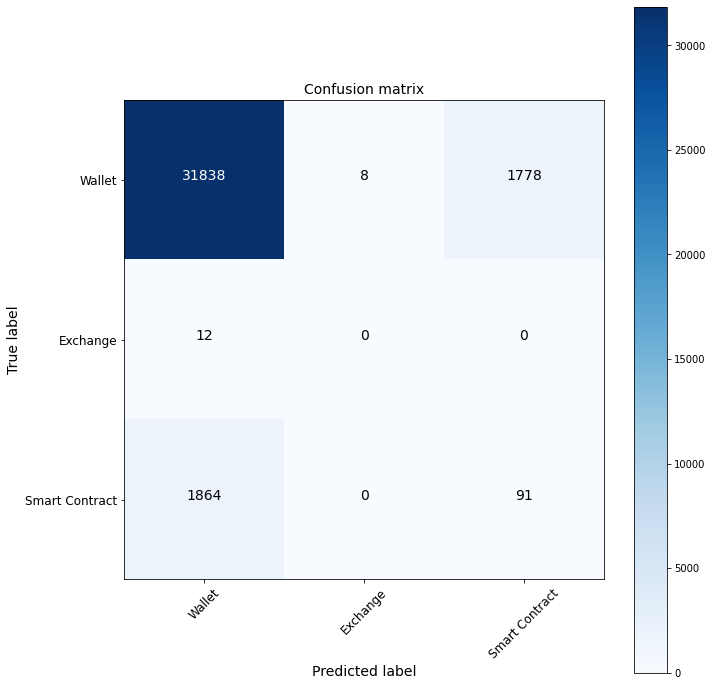

In [36]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(d_matrix, classes)

## Feature Stats and Graphs

The below can mostly be ignored, it consists of statistical analysis of nodes for visualisation

In [38]:
values = []
for tx in transactions:
    values.append(float(tx[2]))

In [39]:
values

[1000.0,
 107.68151,
 1706.0347,
 200.0,
 124.33,
 69.41194136,
 1000.0,
 8.0,
 19.25,
 405.77312,
 119.7794,
 13.76242865824796,
 94.43476999999999,
 99.2,
 8.0,
 203.0,
 778.5036299999999,
 800.0,
 1138.86312813,
 4086.2090000000003,
 120.0,
 1000.0,
 107.68151,
 2.9490918553388483,
 4.295,
 46.73350033,
 3.0,
 1060.503,
 14.285,
 437.60940000000005,
 0.7,
 983.0306184462828,
 3531.0460000000003,
 64.08657,
 87.98289,
 149.75,
 582.8,
 778.5036299999999,
 31.739,
 15925.0,
 200.0,
 15.77286369,
 87.9828,
 18.279,
 10.0,
 49.25,
 40.05639669,
 44.3137,
 150.0,
 15925.0,
 3531.0460000000003,
 170.0,
 983.0306184462828,
 20.303,
 1586.0,
 439.06976389,
 133.0,
 180.0,
 19383.896,
 11.11817,
 445.48336537,
 26.135190903909763,
 5000.0,
 10.294111169999999,
 627.88615028,
 281.6,
 367.99094,
 89.462,
 343.20645999,
 629.65044303,
 10000.0,
 14.289383489999999,
 476.26580715,
 1.81480942,
 9.29,
 710.0,
 66.30639342,
 56.8474,
 886.18514,
 12.60741966,
 62.04719,
 607.92433076,
 1.89873625

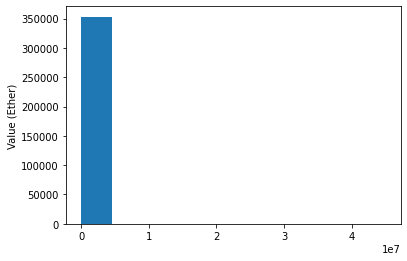

In [40]:
import matplotlib.pyplot as plt
plt.hist(values)
plt.ylabel('Value (Ether)')
plt.show()

(array([2.51570e+04, 1.10047e+05, 2.45160e+04, 8.11800e+03, 3.58800e+03,
        1.81500e+03, 1.07700e+03, 6.91000e+02, 4.74000e+02, 3.45000e+02,
        2.62000e+02, 2.16000e+02, 1.61000e+02, 1.29000e+02, 1.02000e+02,
        9.40000e+01, 1.02000e+02, 7.20000e+01, 1.30000e+02]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

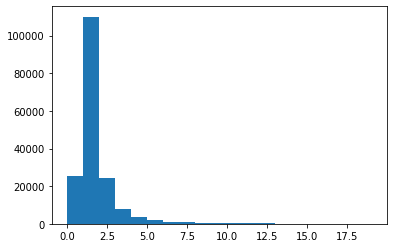

In [41]:
num_txs_in = f_copy[:,0]
plt.hist(num_txs_in, list(range(20)))

In [80]:
for tx in transactions:
    if float(tx[2]) > 10000000:
        print(tx)

['5d1fe002c11de3e42d21684c', '2018-01-02T08:35:44.000+00:00', '45000000', '0xa30d8157911ef23c46c0eb71889efe6a648a41f7', '0x88e343f4599292c2cffe683c1bb93cd3480bdbab', '0x4dff70ebb814418a3402f02e83ff09d50b979cafc8ae225f1d5163608ec7d04b', 'Wallet', 'Wallet']


In [42]:
# in_num, in_min, in_max, in_mean, in_med, in_std,
# out_num, out_min, out_max, out_mean, out_med, out_std,
# comb_num, comb_min, comb_max, comb_mean, comb_med, comb_std,
# in_ts_min, in_ts_max, in_ts_mean, in_ts_med, in_ts_std,
# out_ts_min, out_ts_max, out_ts_mean, out_ts_med, out_ts_std,
# all_ts_min, all_ts_max, all_ts_mean, all_ts_med, all_ts_std

In [43]:
in_num, in_min, in_max, in_mean, in_med, in_std = f_copy[:,0], f_copy[:,1], f_copy[:,2], f_copy[:,3], f_copy[:,4], f_copy[:,5]
out_num, out_min, out_max, out_mean, out_med, out_std = f_copy[:,6], f_copy[:,7], f_copy[:,8], f_copy[:,9], f_copy[:,10], f_copy[:,11]

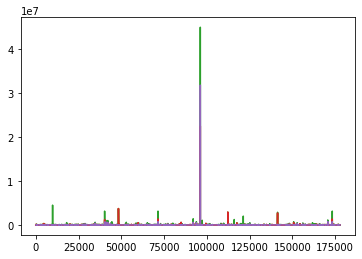

In [44]:
plt.plot(in_num)
plt.plot(in_min)
plt.plot(in_max)
plt.plot(in_mean)
plt.plot(in_std)
plt.show()

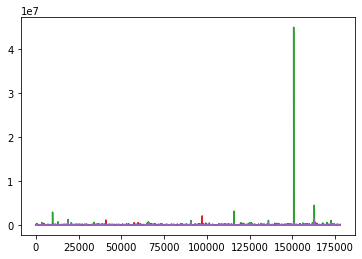

In [45]:
plt.plot(out_num)
plt.plot(out_min)
plt.plot(out_max)
plt.plot(out_mean)
plt.plot(out_std)
plt.show()

In [46]:
hist, bin_edges = np.histogram(in_num)

In [47]:
bin_edges

array([    0. ,  1759.1,  3518.2,  5277.3,  7036.4,  8795.5, 10554.6,
       12313.7, 14072.8, 15831.9, 17591. ], dtype=float32)

In [48]:
hist

array([177946,      4,      0,      1,      0,      1,      2,      0,
            0,      1])

(0.0, 17591.0)

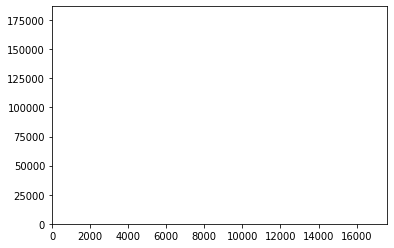

In [49]:
plt.bar(bin_edges[:-1], hist, width=0.5, alpha=0.7)
plt.xlim(min(bin_edges), max(bin_edges))

In [50]:
bin_edges[-1]

17591.0

In [51]:
for node in nodes.values():
    if node.feature_vector()[2] > 10000:
        print(node)
        break

Exchange: 6181 in, 12296 out


In [52]:
values.reverse()

In [53]:
values

[49.64358,
 34.84182635,
 39.72967136,
 47.17898583,
 41.70358,
 41.54452849,
 49.74358,
 2871.6,
 100.0,
 599.7435800000001,
 216.15798857,
 249.34358,
 295.0,
 555.0,
 199.65358,
 3.50911402,
 199.74358,
 128.57738129,
 969.13386767,
 299.54358,
 49.74358,
 105.49,
 49.75058,
 49.64358,
 58.71042067,
 59.1181147,
 61.61958,
 1010.9870000000001,
 2848.5537,
 1438.68336018,
 145.8312,
 78.74358,
 99.64358,
 93.24358,
 62.55014832,
 69.62458001,
 71.37010591,
 999.0,
 311.5161,
 3594.7000000000003,
 1.0,
 102.24358,
 113.52228563,
 99.74358,
 99.74358,
 99.74358,
 120.31358,
 4679.0,
 824.24493,
 225.33444,
 40.71468,
 99.9,
 732.6433,
 936.4516199999999,
 199.65358,
 5.0,
 149.74358,
 198.54358000000002,
 125.95215454999999,
 128.57738129,
 199.74358,
 11.012,
 15.983,
 2000.0,
 125.0,
 20.04387325,
 216.15798857,
 228.82243344999998,
 205.30558000000002,
 249.34358,
 279.18772788,
 20.0,
 39.0,
 299.54358,
 100.0085590728261,
 299.74358,
 599.7435800000001,
 393.74358,
 400.65255374,


In [54]:
nodes['0x2d186dc88a3c3281ac6b5cc5df348739efce1872'].txs_in

[['5d1fe003c11de3e42d2194d6',
  '2018-01-01T00:00:51.000+00:00',
  '124.33',
  '0xfaabe432a1e6843f3486f11fa360a1e1248677fc',
  '0x2d186dc88a3c3281ac6b5cc5df348739efce1872',
  '0x33101cf3b33f5e5aff493d4229ced0d2e29f171bd4328d323f44b9f3ea485ec9',
  'Wallet',
  'Wallet']]

In [55]:
nodes

{'0x6c682d1ceb5d4c3de77e07efdb789450d45f50f7': <__main__.Node at 0x7fa841e2b080>,
 '0x876eabf441b2ee5b5b0554fd502a8e0600950cfa': <__main__.Node at 0x7fa841e2b320>,
 '0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be': <__main__.Node at 0x7fa841e2b390>,
 '0x942c13bf383ee50ae9074b6729460b06a61ac9c5': <__main__.Node at 0x7fa841e2b278>,
 '0xfaabe432a1e6843f3486f11fa360a1e1248677fc': <__main__.Node at 0x7fa841e2b3c8>,
 '0x53f1583df3e367cb42a98845065aeb4b2b59c2f0': <__main__.Node at 0x7fa841e2b438>,
 '0x9ff31955c43cb3ad2e1060d51444e1e69876009a': <__main__.Node at 0x7fa841e2b2b0>,
 '0x726c336610e54606291352842f38a804af2b974d': <__main__.Node at 0x7fa83114af98>,
 '0x2d186dc88a3c3281ac6b5cc5df348739efce1872': <__main__.Node at 0x7fa83114afd0>,
 '0xaeec6f5aca72f3a005af1b3420ab8c8c7009bac8': <__main__.Node at 0x7fa831151048>,
 '0x1764090fbc1b1023f66458f91749f7f07224629b': <__main__.Node at 0x7fa831151080>,
 '0xf4b51b14b9ee30dc37ec970b50a486f37686e2a8': <__main__.Node at 0x7fa8311510b8>,
 '0x749818e4de50

In [56]:
features

array([[5.6847250e-05, 7.1067203e-05, 5.8748888e-06, ..., 2.0547007e-04,
        2.0547007e-04, 0.0000000e+00],
       [4.5477800e-04, 2.0569892e-07, 7.2074226e-06, ..., 6.6851333e-02,
        4.0180814e-02, 1.3382320e-01],
       [1.1369450e-04, 2.6881720e-08, 1.7252667e-07, ..., 2.2830007e-05,
        2.2830007e-05, 0.0000000e+00],
       ...,
       [2.2738900e-04, 1.5024650e-06, 5.7188583e-07, ..., 8.8078171e-02,
        2.1163417e-02, 2.1398060e-01],
       [5.6847250e-05, 1.1125664e-05, 9.1972157e-07, ..., 1.0351125e-01,
        1.0351125e-01, 0.0000000e+00],
       [1.1369450e-04, 1.0268192e-04, 9.0270860e-06, ..., 2.5113008e-04,
        2.5113008e-04, 0.0000000e+00]], dtype=float32)

In [57]:
features_tensor

tensor([[5.6847e-05, 7.1067e-05, 5.8749e-06,  ..., 2.0547e-04, 2.0547e-04,
         0.0000e+00],
        [4.5478e-04, 2.0570e-07, 7.2074e-06,  ..., 6.6851e-02, 4.0181e-02,
         1.3382e-01],
        [1.1369e-04, 2.6882e-08, 1.7253e-07,  ..., 2.2830e-05, 2.2830e-05,
         0.0000e+00],
        ...,
        [2.2739e-04, 1.5025e-06, 5.7189e-07,  ..., 8.8078e-02, 2.1163e-02,
         2.1398e-01],
        [5.6847e-05, 1.1126e-05, 9.1972e-07,  ..., 1.0351e-01, 1.0351e-01,
         0.0000e+00],
        [1.1369e-04, 1.0268e-04, 9.0271e-06,  ..., 2.5113e-04, 2.5113e-04,
         0.0000e+00]], device='cuda:0')

In [59]:
ws = []
scs = []
exs = []
for a, i in node_dict.items():
    if nodes[a].typ == 'Wallet':
        ws.append(i)
    elif nodes[a].typ == 'Smart Contract':
        scs.append(i)
    else:
        exs.append(i)

In [60]:
fs = ['in_num', 'in_min', 'in_max', 'in_mean', 'in_med*', 'in_std',
                'out_num', 'out_min', 'out_max', 'out_mean', 'out_med*', 'out_std',
                'comb_num', 'comb_min', 'comb_max', 'comb_mean', 'comb_med*', 'comb_std',
                'in_ts_min', 'in_ts_max', 'in_ts_mean', 'in_ts_med*', 'in_ts_std',
                'out_ts_min', 'out_ts_max', 'out_ts_mean', 'out_ts_med*', 'out_ts_std',
                'all_ts_min', 'all_ts_max', 'all_ts_mean', 'all_ts_med*', 'all_ts_std']

tensor([1.0230e-04, 1.1621e-04, 2.5564e-05, 3.3191e-05, 3.2136e-05, 1.2605e-05,
        5.2826e-05, 2.5271e-04, 2.1412e-05, 3.3513e-04, 3.1789e-04, 1.6761e-04,
        5.3739e-05, 1.3850e-04, 3.5564e-05, 5.7484e-05, 1.9641e-04, 1.7856e-05,
        1.8637e-02, 3.6042e-02, 2.5478e-02, 2.3928e-02, 1.3461e-02, 1.1176e-02,
        1.9493e-02, 1.4368e-02, 1.3568e-02, 6.5320e-03, 3.2990e-02, 6.6822e-02,
        4.5801e-02, 4.2200e-02, 2.5903e-02], device='cuda:0')


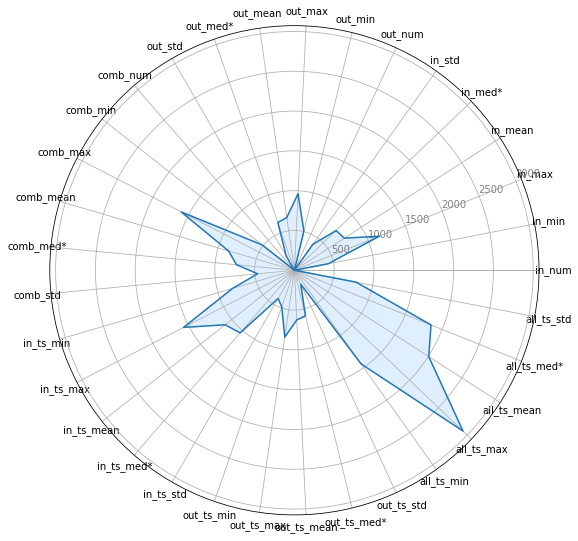

In [63]:
ws_agg = features_tensor[ws]
ws_agg2 = f_copy[ws]
ws_avg = ws_agg.mean(axis=0)
ws_avg2 = ws_agg2.mean(axis=0)
print(ws_avg)

N = len(fs)
ws_avg = list(ws_avg)
ws_avg += ws_avg[:1]
ws_avg2 = list(ws_avg2)
ws_avg2 += ws_avg2[:1]
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(9,9))

plt.polar(angles, ws_avg2)
plt.fill(angles, ws_avg2, alpha=0.3, color='#99ccff')
plt.xticks(angles, fs)
# fig.set_rlabel_position(0)
plt.yticks(color='grey', size=10)
plt.show()

tensor([1.0456e-04, 2.7555e-04, 4.4519e-05, 6.4210e-05, 6.1282e-05, 1.6895e-05,
        1.7097e-04, 6.4951e-04, 4.7081e-05, 8.2128e-04, 7.9862e-04, 3.6005e-04,
        1.2742e-04, 2.8813e-04, 5.0413e-05, 1.0396e-04, 4.0199e-04, 2.0567e-05,
        3.1101e-02, 6.6923e-02, 4.5690e-02, 4.2418e-02, 2.8962e-02, 4.2169e-02,
        6.4457e-02, 5.2020e-02, 5.0775e-02, 1.9352e-02, 1.7809e-02, 8.3963e-02,
        3.7247e-02, 2.3106e-02, 4.5404e-02], device='cuda:0')


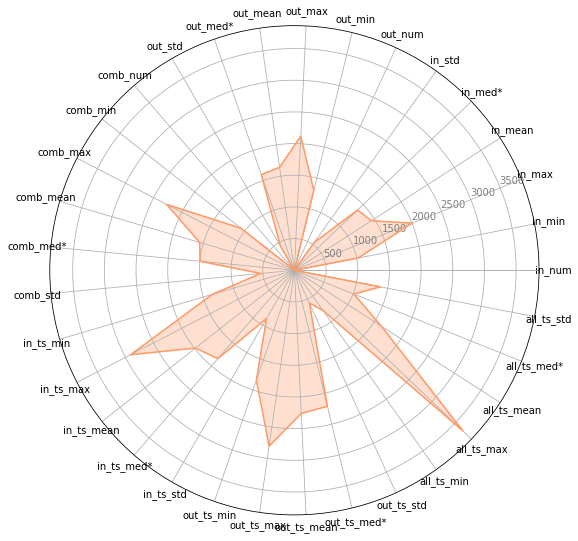

In [64]:
ws_agg = features_tensor[scs]
ws_agg2 = f_copy[scs]
ws_avg = ws_agg.mean(axis=0)
ws_avg2 = ws_agg2.mean(axis=0)
print(ws_avg)

N = len(fs)
ws_avg = list(ws_avg)
ws_avg += ws_avg[:1]
ws_avg2 = list(ws_avg2)
ws_avg2 += ws_avg2[:1]
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(9,9))

plt.polar(angles, ws_avg2, color='#ff9966')
plt.fill(angles, ws_avg2, alpha=0.3, color='#ff9966')
plt.xticks(angles, fs)
# fig.set_rlabel_position(0)
plt.yticks(color='grey', size=10)
plt.show()

tensor([4.9028e-02, 4.0298e-02, 1.3715e-02, 8.4047e-03, 6.9029e-03, 2.6960e-03,
        1.2565e-01, 7.8788e-05, 3.1009e-02, 1.1014e-03, 4.2983e-04, 1.7361e-02,
        1.0015e-01, 1.8631e-02, 4.0919e-02, 4.9061e-03, 1.8867e-02, 1.1479e-03,
        1.3215e-02, 2.3894e-01, 3.5991e-02, 2.5058e-02, 6.8709e-02, 2.3709e-04,
        6.0562e-02, 6.4106e-03, 3.5978e-03, 1.2790e-02, 4.7282e-04, 7.4979e-02,
        1.2782e-02, 1.1188e-02, 2.7839e-02], device='cuda:0')


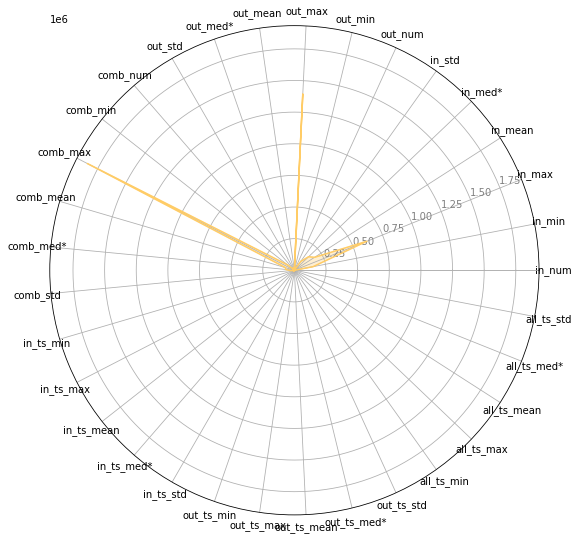

In [65]:
ws_agg = features_tensor[exs]
ws_agg2 = f_copy[exs]
ws_avg = ws_agg.mean(axis=0)
ws_avg2 = ws_agg2.mean(axis=0)
print(ws_avg)

N = len(fs)
ws_avg = list(ws_avg)
ws_avg += ws_avg[:1]
ws_avg2 = list(ws_avg2)
ws_avg2 += ws_avg2[:1]
angles = [n / float(N) * 2 * math.pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(9,9))

plt.polar(angles, ws_avg2, color='#ffcc66')
plt.fill(angles, ws_avg2, alpha=0.3, color='#ffcc66')
plt.xticks(angles, fs)
# fig.set_rlabel_position(0)
plt.yticks(color='grey', size=10)
plt.show()

In [66]:
f_copy[exs][:, 6]

array([2.0200e+02, 1.2296e+04, 1.8410e+03, 1.7140e+03, 1.1200e+02,
       8.0500e+02, 8.6640e+03, 1.0000e+00, 1.7500e+03, 1.0000e+01,
       1.5369e+04, 1.0000e+00, 6.1000e+01, 5.2000e+01, 9.1130e+03,
       3.2000e+01, 1.7670e+03, 1.8080e+03, 7.0000e+00, 4.2150e+03,
       2.0009e+04, 1.7270e+03, 7.3500e+02, 3.9000e+01, 1.7160e+03,
       0.0000e+00, 6.7000e+01, 3.3070e+03, 9.5000e+01, 5.8480e+03,
       1.7440e+03, 1.9510e+03, 5.9700e+02, 3.9500e+02, 1.7590e+03,
       9.0810e+03, 6.7600e+02, 7.9400e+02], dtype=float32)

In [67]:
addresses[exs]

array([['0xe03c23519e18d64f144d2800e30e81b0065c48b5'],
       ['0x876eabf441b2ee5b5b0554fd502a8e0600950cfa'],
       ['0xadb2b42f6bd96f5c65920b9ac88619dce4166f94'],
       ['0x5c985e89dde482efe97ea9f1950ad149eb73829b'],
       ['0x8958618332df62af93053cb9c535e26462c959b0'],
       ['0xa8660c8ffd6d578f657b72c0c811284aef0b735e'],
       ['0x0681d8db095565fe8a346fa0277bffde9c0edbbf'],
       ['0x167a9333bf582556f35bd4d16a7e80e191aa6476'],
       ['0x1062a747393198f70f71ec65a582423dba7e5ab3'],
       ['0xa12431d0b9db640034b0cdfceef9cce161e62be4'],
       ['0xaeec6f5aca72f3a005af1b3420ab8c8c7009bac8'],
       ['0x1ce7ae555139c5ef5a57cc8d814a867ee6ee33d8'],
       ['0x0a73573cf2903d2d8305b1ecb9e9730186a312ae'],
       ['0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208'],
       ['0x564286362092d8e7936f0549571a803b203aaced'],
       ['0xe17ee7b3c676701c66b395a35f0df4c2276a344e'],
       ['0xab5c66752a9e8167967685f1450532fb96d5d24f'],
       ['0xeee28d484628d41a82d01e21d12e2e78d69920da'],
       ['0

In [70]:
fs = ['in_num', 'in_min', 'in_max', 'in_mean', 'in_med', 'in_std',
                'out_num', 'out_min', 'out_max', 'out_mean', 'out_med', 'out_std',
                'comb_num', 'comb_min', 'comb_max', 'comb_mean', 'comb_med', 'comb_std',
                'in_ts_min', 'in_ts_max', 'in_ts_mean', 'in_ts_med', 'in_ts_std',
                'out_ts_min', 'out_ts_max', 'out_ts_mean', 'out_ts_med', 'out_ts_std',
                'all_ts_min', 'all_ts_max', 'all_ts_mean', 'all_ts_med', 'all_ts_std']

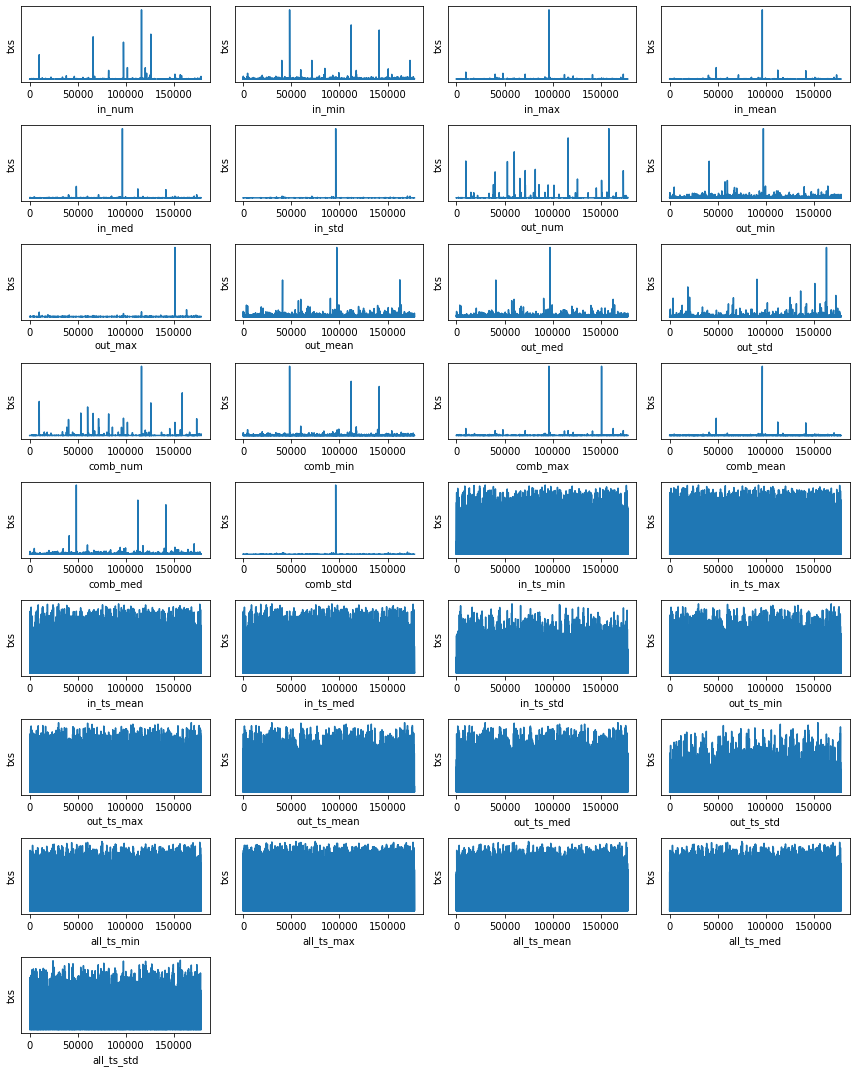

In [71]:
fig, axs = plt.subplots(9, 4, figsize=(12,15))
bins = 50

N = len(fs)
for l in range(N):
    i = l // 4
    j = l % 4
    axs[i][j].plot(features_tensor.cpu()[:,l])
    axs[i][j].set_xlabel(fs[l])
    axs[i][j].set_ylabel('txs')
    axs[i][j].set_yticks([])

fig.delaxes(axs[8,1])
fig.delaxes(axs[8,2])
fig.delaxes(axs[8,3])
fig.tight_layout()
plt.show()

In [72]:
values

[49.64358,
 34.84182635,
 39.72967136,
 47.17898583,
 41.70358,
 41.54452849,
 49.74358,
 2871.6,
 100.0,
 599.7435800000001,
 216.15798857,
 249.34358,
 295.0,
 555.0,
 199.65358,
 3.50911402,
 199.74358,
 128.57738129,
 969.13386767,
 299.54358,
 49.74358,
 105.49,
 49.75058,
 49.64358,
 58.71042067,
 59.1181147,
 61.61958,
 1010.9870000000001,
 2848.5537,
 1438.68336018,
 145.8312,
 78.74358,
 99.64358,
 93.24358,
 62.55014832,
 69.62458001,
 71.37010591,
 999.0,
 311.5161,
 3594.7000000000003,
 1.0,
 102.24358,
 113.52228563,
 99.74358,
 99.74358,
 99.74358,
 120.31358,
 4679.0,
 824.24493,
 225.33444,
 40.71468,
 99.9,
 732.6433,
 936.4516199999999,
 199.65358,
 5.0,
 149.74358,
 198.54358000000002,
 125.95215454999999,
 128.57738129,
 199.74358,
 11.012,
 15.983,
 2000.0,
 125.0,
 20.04387325,
 216.15798857,
 228.82243344999998,
 205.30558000000002,
 249.34358,
 279.18772788,
 20.0,
 39.0,
 299.54358,
 100.0085590728261,
 299.74358,
 599.7435800000001,
 393.74358,
 400.65255374,


Text(0.5, 0, 'Transaction value')

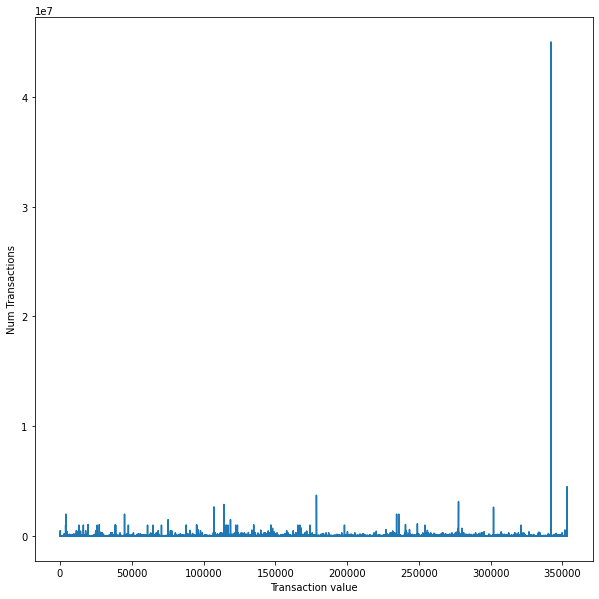

In [73]:
fig, axs = plt.subplots(figsize=(10,10))
axs.plot(values)
axs.set_ylabel('Num Transactions')
axs.set_xlabel('Transaction value')